In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import voigt_profile
from scipy import integrate, interpolate
from lmfit import minimize, Parameters
import emcee
import corner
import pandas as pd

In [2]:
plt.style.use('/Users/thepoetoftwilight/Documents/CUBS/Code/science.mplstyle')

Specify atomic parameters for LyA

In [3]:
wav0_rest = 1215.6701
f = 0.416400
gamma_nu = 6.265E8

Convert $\Gamma_\nu$ to $\Gamma_v$ (must be done in the rest frame)

In [4]:
# First convert wavelength to meters, then velocity to km/s
gamma_v = (gamma_nu*(wav0_rest*1e-10))*1e-3

Thomson scattering cross-section

In [5]:
sigma_0 = 2.654E-2 # In cm^-2

Specify the redshift, wavelength range of observation, and velocity pixel size

In [6]:
z_test = 0.1
wav0_obs_min = 1250
wav0_obs_max = 1450
delta_v_pix = 2.3

Use this information to generate the velocity array

In [7]:
wav0_obs = wav0_rest*(1+z_test) # Observed wavelength of transition
v_min = 3e+5*(wav0_obs_min-wav0_obs)/wav0_obs
v_max = 3e+5*(wav0_obs_max-wav0_obs)/wav0_obs
v = np.arange(v_min, v_max+delta_v_pix, delta_v_pix)

Generate the Ly$\alpha$ lines

In [8]:
N = 1e+14 # cm^-2
b = 12.9
sigma_v = b/np.sqrt(2)

In [9]:
def vp(v, logN):
    
    tau = 10**logN*sigma_0*f*voigt_profile(v, sigma_v, gamma_v/(4*np.pi))*wav0_rest*1e-13
    flux = np.exp(-tau)
    
    return flux

In [10]:
flux = vp(v, np.log10(N))

Text(0, 0.5, 'Continuum normalized flux')

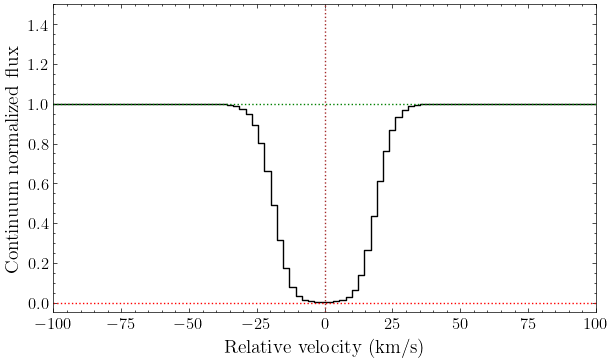

In [13]:
fig, ax = plt.subplots(1, figsize=(7,4))
ax.step(v, flux, where='mid')

ax.axhline(0, linestyle=':', color='red')
ax.axhline(1, linestyle=':', color='green')
ax.axvline(0, linestyle=':', color='brown')


ax.set_xlim(-100,100)
ax.set_ylim(-0.05,1.5)

ax.set_xlabel('Relative velocity (km/s)')
ax.set_ylabel('Continuum normalized flux')

Create the noisy data

In [14]:
err_std = 0.15
# Draw samples from a Gaussian of mean zero and above std dev
np.random.seed(45)
pert = np.random.normal(loc=0, scale=err_std, size=len(v))
flux_pert = flux+pert
err_pert = np.ones(len(v))*err_std

Text(0, 0.5, 'Continuum normalized flux')

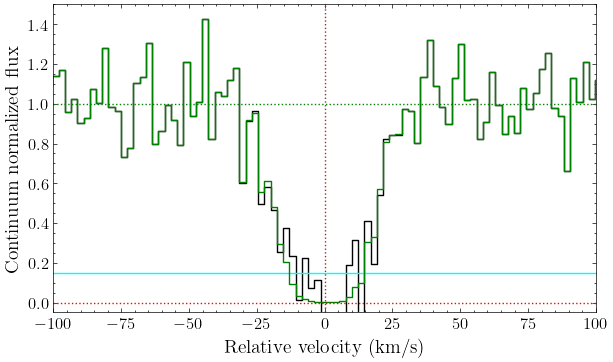

In [15]:
fig, ax = plt.subplots(1, figsize=(7,4))
ax.step(v, flux_pert, where='mid')
ax.step(v, err_pert, color='cyan', where='mid')
ax.step(v, (1+pert)*flux, color='green', where='mid')

ax.axhline(0, linestyle=':', color='red')
ax.axhline(1, linestyle=':', color='green')
ax.axvline(0, linestyle=':', color='brown')


ax.set_xlim(-100,100)
ax.set_ylim(-0.05,1.5)

ax.set_xlabel('Relative velocity (km/s)')
ax.set_ylabel('Continuum normalized flux')

Calculate EW within a window equal to twice of the FWHM

In [14]:
fwhm = 2*np.sqrt(2*np.log(2))*sigma_v

In [15]:
idx_ew = (v>-fwhm)&(v<fwhm)

Text(0, 0.5, 'Flux (continuum normalized)')

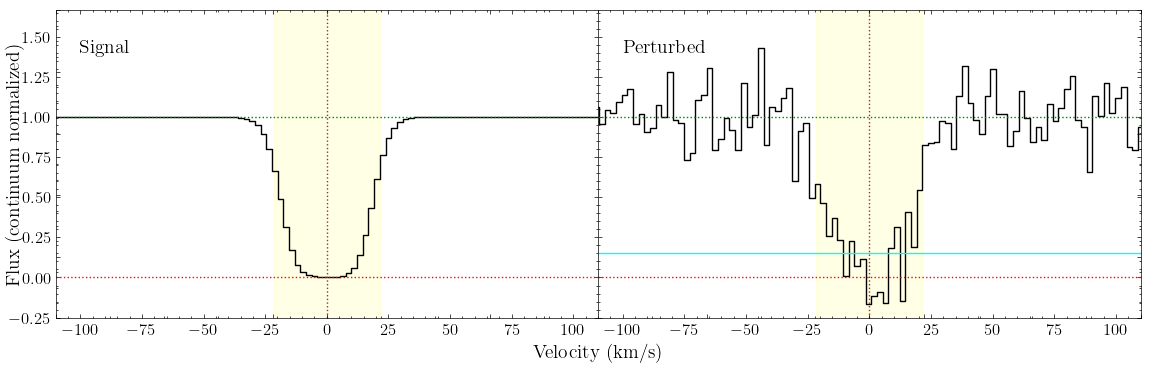

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14,4), sharex=True, sharey=True)

axes[0].step(v, flux, where='mid')
axes[0].axvspan(xmin=-fwhm, xmax=fwhm, color='yellow', alpha=.1)
axes[0].axhline(0, linestyle=':', color='red')
axes[0].axhline(1, linestyle=':', color='green')
axes[0].axvline(0, linestyle=':', color='brown')
axes[0].text(x=-100, y=1.4, s='Signal')

axes[0].set_xlim(-110,110)

axes[1].step(v, flux_pert, where='mid')
axes[1].step(v, err_pert, where='mid', color='cyan')
axes[1].axvspan(xmin=-fwhm, xmax=fwhm, color='yellow', alpha=.1)
axes[1].axhline(0, linestyle=':', color='red')
axes[1].axhline(1, linestyle=':', color='green')
axes[1].axvline(0, linestyle=':', color='brown')
axes[1].text(x=-100, y=1.4, s='Perturbed')

plt.subplots_adjust(wspace=0, hspace=0)

ax_label = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')

ax_label.set_xlabel('Velocity (km/s)') # Use argument `labelpad` to move label downwards.
ax_label.set_ylabel('Flux (continuum normalized)')

In [17]:
# Calculate EW of the unperturbed and perturbed feature in mÅ

EW = np.sum(1-flux[idx_ew][:-1])*(delta_v_pix*wav0_rest/3e+5)*1e+3
EW_pert = np.sum(1-flux_pert[idx_ew][:-1])*(delta_v_pix*wav0_rest/3e+5)*1e+3
sig_EW_pert = np.sqrt(np.sum(err_pert[idx_ew][:-1]**2))*(delta_v_pix*wav0_rest/3e+5)*1e+3

In [18]:
EW, EW_pert, sig_EW_pert

(142.3557634255466, 142.0065980035638, 5.931299142630524)

In [19]:
np.log10((EW*1e-3/wav0_rest)*(3e+8/(wav0_rest*1e-10))*(2.654e-2*f)**-1)

13.417453199781207

In [20]:
np.log10((EW_pert*1e-3/wav0_rest)*(3e+8/(wav0_rest*1e-10))*(2.654e-2*f)**-1)

13.416386668391564

In [21]:
EW_pert/sig_EW_pert

23.94190456234248

In [22]:
3*sig_EW_pert

17.793897427891572

In [23]:
# Column density estimate from linear regime of curve of growth
logN_EW_UL = np.log10((3*sig_EW_pert*1e-3/wav0_rest)*(3e+8/(wav0_rest*1e-10))*(2.654e-2*f)**-1)

In [24]:
logN_EW_UL

12.514349227833831

Calculate a grid of $\chi^2$

In [25]:
# Define grid of logN
logN_grid = np.arange(5, 16.5, 0.05)
chi_sq_grid = np.zeros(len(logN_grid))

In [26]:
# Define FWHM
fwhm = 2*np.sqrt(np.log(2))*b
idx = (v>-fwhm)&(v<fwhm)

In [27]:
# Number of pixels considered
len(v[idx])

19

In [28]:
# Perform the calculation
for i in range(len(logN_grid)):

    model_flux = flux = vp(v, logN_grid[i])
    
    chi_sq_grid[i] = np.sum(((model_flux[idx]-flux_pert[idx])/err_pert[idx])**2)

In [29]:
delta_chi_sq_grid = chi_sq_grid-np.min(chi_sq_grid)

In [30]:
logN_base = logN_grid[np.argmin(delta_chi_sq_grid)]
logN_1sig = logN_grid[logN_grid>logN_base][np.argmin(np.abs(delta_chi_sq_grid[logN_grid>logN_base]-1))]
logN_2sig = logN_grid[logN_grid>logN_base][np.argmin(np.abs(delta_chi_sq_grid[logN_grid>logN_base]-4))]
logN_3sig = logN_grid[logN_grid>logN_base][np.argmin(np.abs(delta_chi_sq_grid[logN_grid>logN_base]-9))]

Text(0, 0.5, '$\\chi^2$')

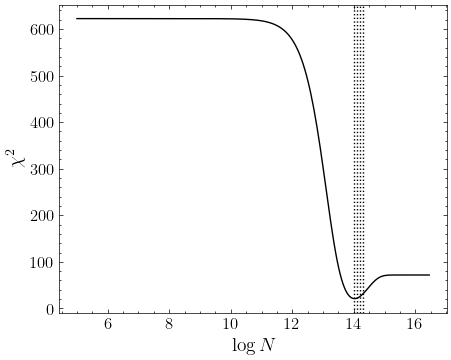

In [31]:
fig, ax = plt.subplots(1, figsize=(5,4))

ax.plot(logN_grid, chi_sq_grid)

ax.axvline(logN_base, linestyle=':')
ax.axvline(logN_1sig, linestyle=':')
ax.axvline(logN_2sig, linestyle=':')
ax.axvline(logN_3sig, linestyle=':')



#ax.set_ylim(15, 40)
ax.set_xlabel(r'$\log N$')
ax.set_ylabel(r'$\chi^2$')

In [32]:
logN_base

13.999999999999968

In [33]:
logN_1sig-logN_base, logN_2sig-logN_1sig, logN_3sig-logN_2sig

(0.09999999999999964, 0.09999999999999964, 0.09999999999999964)

In [34]:
logN_3sig

14.299999999999967

Text(0, 0.5, 'Continuum normalized flux')

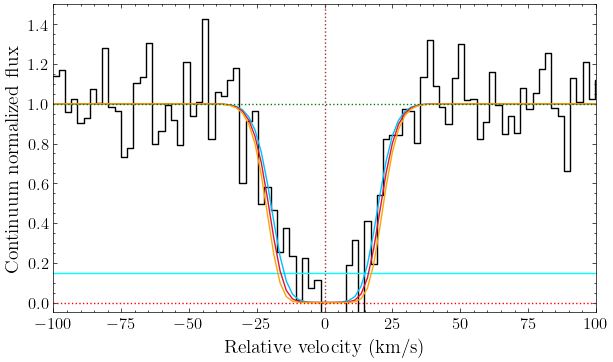

In [35]:
fig, ax = plt.subplots(1, figsize=(7,4))
ax.step(v, flux_pert, where='mid')
ax.step(v, err_pert, color='cyan', where='mid')
ax.plot(v, vp(v, logN_1sig))
ax.plot(v, vp(v, logN_2sig))
ax.plot(v, vp(v, logN_3sig))

ax.axhline(0, linestyle=':', color='red')
ax.axhline(1, linestyle=':', color='green')
ax.axvline(0, linestyle=':', color='brown')

ax.set_xlim(-100,100)
ax.set_ylim(-0.05,1.5)

ax.set_xlabel('Relative velocity (km/s)')
ax.set_ylabel('Continuum normalized flux')

Calculate detection significance

In [36]:
P_alt = np.exp(-0.5*np.min(chi_sq_grid))
P_null = np.exp(-0.5*np.sum(((1-flux_pert[idx])/err_pert[idx])**2))

In [37]:
np.min(chi_sq_grid)

21.05277929634694

In [38]:
np.sum(((1-flux_pert[idx])/err_pert[idx])**2)

622.3674583381656

In [39]:
P_alt/P_null

3.748206397950368e+130